# Анализ картинок

Создайте эмбеддинги изображений и отобразите их в tensorboard projector'е

1. Скачайте датасет [CelebA](https://pytorch.org/vision/stable/datasets.html#celeba) или любой другой не рассмотренный на лекции
1. Выберите одну из предобученных [моделей torchvision](https://pytorch.org/vision/stable/models.html)
1. Создайте эмбеддинги изображений из датасета
1. Визуализируйте эмбеддинги в tensorboard projector

# Лена

Примените фильтр к изображению Лены

1. Скачайте изображение [Лены](http://optipng.sourceforge.net/pngtech/img/lena.png)
1. Найдите фильтр для выделения признака на изображении. В лекции показан пример фильтра Собеля. Использовать примеры с лекций нельзя. Начать поиск фильтра можно с [этой страницы](https://en.wikipedia.org/wiki/Feature_(computer_vision)#Extraction)
1. Реализуйте процедуру свёртки изображения с фильтром
1. Сверните Лену

In [2]:
import random
import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet50

from tqdm.notebook import tqdm, trange

# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

poke_classes = [
    'Grass',
    'Fire',
    'Water',
    'Bug',
    'Normal',
    'Poison',
    'Electric',
    'Ground',
    'Fairy',
    'Fighting',
    'Psychic',
    'Rock',
    'Ghost',
    'Ice',
    'Dragon',
    'Dark',
    'Steel',
    'Flying',
]

OUTPUT_DIM = len(poke_classes)  # Количество классов
EPOCH_NUM = 40 # Сколько эпох будет обучать модель

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
basic_transform = transforms.Compose([
    transforms.Pad(15, 255),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(120),
    transforms.ToTensor()
])  # Базовые аугментации для тренировочных данных (грубо говоря бесплатное увеличение тренировочной выборки)

In [4]:
import os.path
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from PIL import ImageDraw
from PIL import Image

class PokemonImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.png')
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')

        image = Image.open(img_path).convert('RGBA')
        new_image = Image.new('RGBA', image.size, 'WHITE')
        new_image.paste(image, mask=image)
        image = new_image.convert('RGB')

        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
# Загрузим данные

"""
full_dataset = PokemonImageDataset(
    img_dir='./archive2/images/images',
    annotations_file='./archive2/pokemon.csv',
    transform=basic_transform,
    target_transform=poke_classes.index
)
"""

def img_loader(path):
    img = Image.open(path).convert('RGBA')
    new_image = Image.new('RGBA', img.size, 'WHITE')
    new_image.paste(img, mask=img)
    return new_image.convert('RGB')

basic_transform = transforms.Compose([
    torchvision.transforms.Resize(64),
    # transforms.Pad(4),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64),
    transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

full_dataset = torchvision.datasets.ImageFolder('archive6/', transform=basic_transform, loader=img_loader)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [6]:
# Создадим DataLoader'ы (для того чтобы было проще итерироваться)

dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=16,
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=16,
        shuffle=False
    )
}

In [7]:
# Создадим класс нашей модели

# Так как мы хотим использовать все фишки библиотеки Pytorch важно наследоваться от nn.Module
class PokeClassifier(nn.Module):
    def __init__(self, output_dim):
        super(PokeClassifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = resnet50(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели

        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False

        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, output_dim)
        )

    def embed(self, x):
        return self.fc1(self.model(x))

    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [8]:
model = PokeClassifier(OUTPUT_DIM)
model = model.to(DEVICE)  # Переносим модель на GPU

In [9]:
# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
# Более подробно об этом будет в курсе машинного обучения
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [10]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Важно! В данном примере точность используется для упрощения.
# Никогда не используйте её если у вас несбалансированная выборка
# Возьмите лучше F_score или ROC_AUC (об этом вам потом расскажут)

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):

    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]

        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train()
        elif phase == 'val':
            model.eval()

        running_loss = 0.
        running_acc = 0.

        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            # X_batch = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_batch)

            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)

                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)

                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()

            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')

        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.7830 Acc: 0.1502 

Epoch: 1. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.6069 Acc: 0.2236 

Epoch: 2. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.5714 Acc: 0.2096 

Epoch: 2. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.5264 Acc: 0.2423 

Epoch: 3. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.5047 Acc: 0.2336 

Epoch: 3. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.4633 Acc: 0.2553 

Epoch: 4. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.4416 Acc: 0.2363 

Epoch: 4. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.4178 Acc: 0.2642 

Epoch: 5. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.4013 Acc: 0.2544 

Epoch: 5. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.3908 Acc: 0.2815 

Epoch: 6. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.3640 Acc: 0.2752 

Epoch: 6. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.3588 Acc: 0.2772 

Epoch: 7. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.3414 Acc: 0.2667 

Epoch: 7. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.3448 Acc: 0.2848 

Epoch: 8. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.3263 Acc: 0.2691 

Epoch: 8. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.3278 Acc: 0.2884 

Epoch: 9. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.2984 Acc: 0.2803 

Epoch: 9. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.3140 Acc: 0.2914 

Epoch: 10. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.2730 Acc: 0.2893 

Epoch: 10. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.3103 Acc: 0.2913 

Epoch: 11. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.2608 Acc: 0.2850 

Epoch: 11. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2840 Acc: 0.2973 

Epoch: 12. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.2466 Acc: 0.2908 

Epoch: 12. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2907 Acc: 0.2954 

Epoch: 13. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.2500 Acc: 0.2926 

Epoch: 13. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2844 Acc: 0.3056 

Epoch: 14. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.2346 Acc: 0.2937 

Epoch: 14. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2634 Acc: 0.2909 

Epoch: 15. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.2009 Acc: 0.3080 

Epoch: 15. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2514 Acc: 0.2944 

Epoch: 16. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1965 Acc: 0.3096 

Epoch: 16. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2602 Acc: 0.2938 

Epoch: 17. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1955 Acc: 0.3040 

Epoch: 17. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2324 Acc: 0.3079 

Epoch: 18. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1881 Acc: 0.3116 

Epoch: 18. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2302 Acc: 0.2927 

Epoch: 19. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1815 Acc: 0.3148 

Epoch: 19. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2307 Acc: 0.3055 

Epoch: 20. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1635 Acc: 0.3086 

Epoch: 20. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2472 Acc: 0.3045 

Epoch: 21. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1761 Acc: 0.3005 

Epoch: 21. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2197 Acc: 0.2914 

Epoch: 22. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1419 Acc: 0.3184 

Epoch: 22. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2183 Acc: 0.3050 

Epoch: 23. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1428 Acc: 0.3172 

Epoch: 23. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2212 Acc: 0.3084 

Epoch: 24. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1365 Acc: 0.3173 

Epoch: 24. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2200 Acc: 0.3073 

Epoch: 25. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1322 Acc: 0.3199 

Epoch: 25. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2233 Acc: 0.3020 

Epoch: 26. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1239 Acc: 0.3233 

Epoch: 26. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2262 Acc: 0.2908 

Epoch: 27. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1025 Acc: 0.3280 

Epoch: 27. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2166 Acc: 0.2901 

Epoch: 28. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1273 Acc: 0.3210 

Epoch: 28. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2104 Acc: 0.2978 

Epoch: 29. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1162 Acc: 0.3275 

Epoch: 29. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1879 Acc: 0.3132 

Epoch: 30. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.1051 Acc: 0.3285 

Epoch: 30. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2086 Acc: 0.3072 

Epoch: 31. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0972 Acc: 0.3312 

Epoch: 31. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2088 Acc: 0.3025 

Epoch: 32. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0857 Acc: 0.3352 

Epoch: 32. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.2092 Acc: 0.2990 

Epoch: 33. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0916 Acc: 0.3241 

Epoch: 33. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1719 Acc: 0.3100 

Epoch: 34. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0915 Acc: 0.3321 

Epoch: 34. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1898 Acc: 0.3050 

Epoch: 35. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0797 Acc: 0.3309 

Epoch: 35. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1890 Acc: 0.3117 

Epoch: 36. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0779 Acc: 0.3366 

Epoch: 36. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1800 Acc: 0.3057 

Epoch: 37. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0901 Acc: 0.3248 

Epoch: 37. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1745 Acc: 0.3026 

Epoch: 38. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0872 Acc: 0.3274 

Epoch: 38. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1953 Acc: 0.3032 

Epoch: 39. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0615 Acc: 0.3324 

Epoch: 39. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1747 Acc: 0.3073 

Epoch: 40. Phase: train:   0%|          | 0/424 [00:00<?, ?it/s]

train Loss: 2.0479 Acc: 0.3352 

Epoch: 40. Phase: val:   0%|          | 0/106 [00:00<?, ?it/s]

val Loss: 2.1763 Acc: 0.3085 

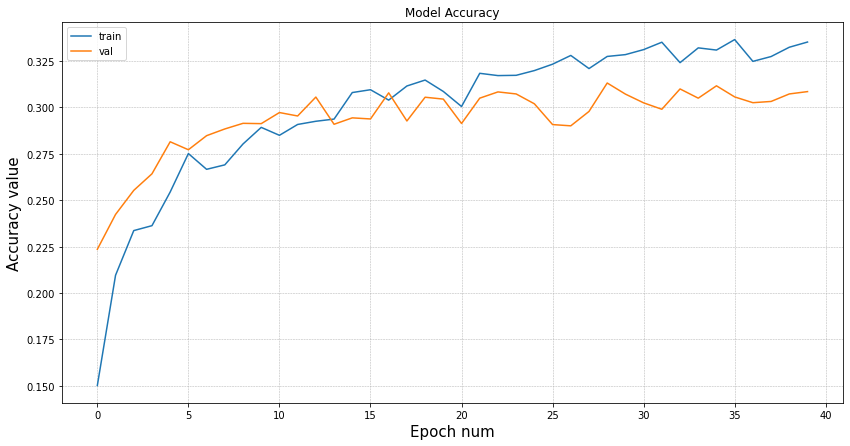

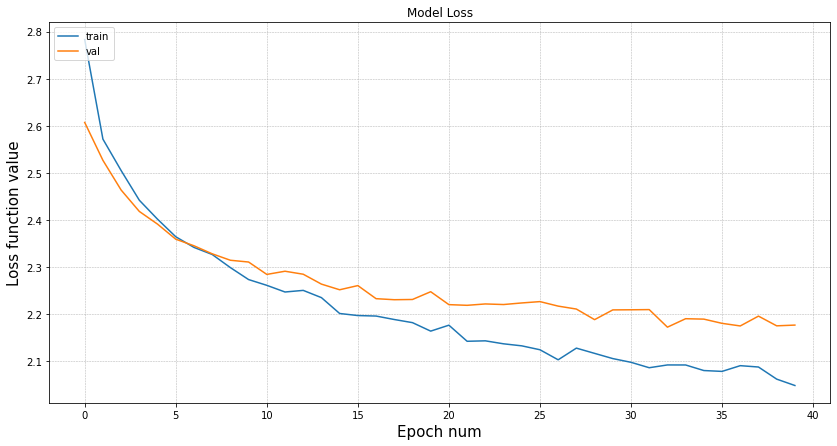

In [11]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

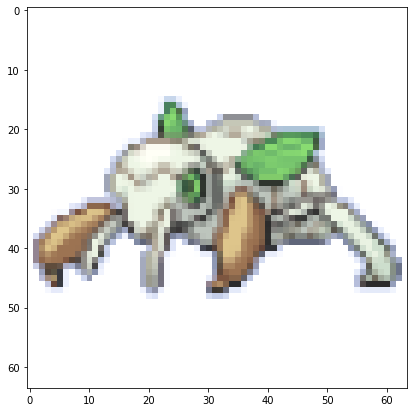

In [12]:
img = full_dataset[112][0].detach().numpy()

plt.imshow(np.transpose(img, (1,2,0)))

In [13]:
train_items = [train_dataset[i] for i in range(500)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
# xs = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(xs)
xs.size()

torch.Size([500, 3, 64, 64])

In [20]:
xs_device = xs.to(DEVICE)
embs = model.embed(xs_device)
embs.size()

torch.Size([500, 18])

torch.Size([500, 64])

In [15]:
import umap

In [16]:
points = umap.UMAP().fit_transform(embs.cpu().detach().numpy())
points.shape

(500, 2)

In [17]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()
features = xs.mean(dim=1).view(-1, 64 * 64)
writer.add_embedding(features,
                     metadata=ys,
                     label_img=xs)
writer.close()

In [18]:
def convolve(image, the_filter):
    ishp = image.shape
    the_filter = the_filter.reshape(the_filter.shape + (1,) * (len(ishp) - len(the_filter.shape)))
    fshp = the_filter.shape
    return np.array(
        [
            [np.sum(image[i:i + fshp[0], j:j + fshp[1]] * the_filter, axis=(0, 1))
             for j in range(0, ishp[1] - fshp[1])] for i in range(0, ishp[0] - fshp[0])
        ]
    )

19


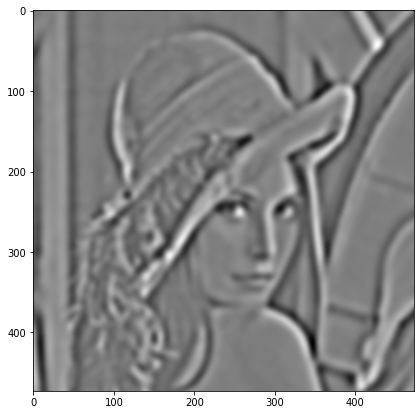

In [19]:
sobel_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
sobel_y = np.transpose(sobel_x)

def gaussian_filter(r, sigma):
    return np.array(
        [
            [1 / (2 * np.pi * sigma**2) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
             for x in range(-r, r + 1)] for y in range(-r, r + 1)
        ]
    )

img = np.array(Image.open('lena.png').convert('L'))
img = img / 255
sigma = 1 / np.sqrt(2 * np.pi) * 17
r = int(np.floor(3 * sigma - 0.5))
print(r)
g = gaussian_filter(r, sigma / 1.6) - gaussian_filter(r, sigma)
new_img = convolve(img, g)
plt.imshow(new_img, cmap='gray');